In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

from gensim.test.utils import datapath

import heapq

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Mon Aug  8 14:55:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 26%   34C    P8    20W / 260W |     19MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 25%   

# LDA

## all brief paragraph

In [3]:
de_desc=[]
for i in range(2012,2021):
    file_path = "../LDA/segment/data/de_file_brief_paragraph_{}.txt".format(i)
    file_de = open(file_path, "r")
    de_lines = file_de.readlines()
    de_desc_year = [i.replace(" \n","").split(" ") for i in de_lines]
    de_desc += de_desc_year
    print(i,"=============")
    print(len(de_desc_year))
    

2012 =============
7
2013 =============
7
2014 =============
12
2015 =============
37
2016 =============
88
2017 =============
199
2018 =============
230
2019 =============
242
2020 =============
243


In [4]:
len(de_desc)

1065

In [5]:
id2word = corpora.Dictionary(de_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(11898 unique tokens: ['\n', 'al', 'besonders', 'bestimmte', 'betrifft']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in de_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [19]:
topic_num_list = np.arange(2, 30, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


,topic_num,gensim_perplexity,perplexity
0,2,-8.175322,3552.198632
1,3,-8.172650,3542.720963
2,4,-8.165506,3517.501234
3,5,-8.160846,3501.148014
4,6,-8.149876,3462.948224
5,7,-8.149663,3462.210869
6,8,-8.143058,3439.418590
7,9,-8.139506,3427.224681
8,10,-8.142462,3437.369533
9,11,-8.136409,3416.625687


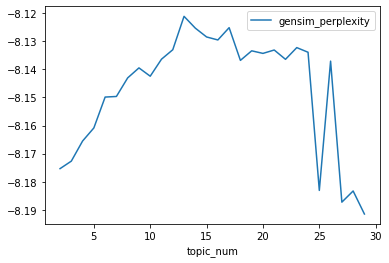

In [23]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-8.175322,3552.198632
1,3,-8.172650,3542.720963
2,4,-8.165506,3517.501234
3,5,-8.160846,3501.148014
4,6,-8.149876,3462.948224
5,7,-8.149663,3462.210869
6,8,-8.143058,3439.418590
7,9,-8.139506,3427.224681
8,10,-8.142462,3437.369533
9,11,-8.136409,3416.625687


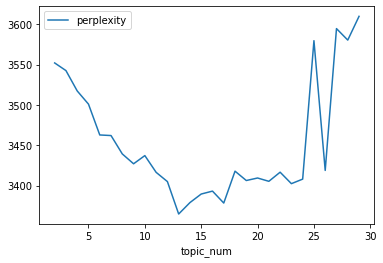

In [24]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [25]:
# 儲存LDA_result
result.to_csv("./result/LDA_de_brief_paragraph_all.csv", index=False)

## 找出文章topic

In [7]:
# best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]
best_num = 13

In [8]:
best_num

13

In [9]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [10]:
ldamodel.print_topics(num_words=100)

[(0,
  '0.025*"de" + 0.012*"mindestens" + 0.006*"mobilen" + 0.006*"ersten" + 0.005*"al" + 0.005*"wobei" + 0.005*"zweiten" + 0.005*"headendsystem" + 0.004*"umfasst" + 0.004*"verfahren" + 0.004*"ausgelegt" + 0.004*"datensammler" + 0.004*"empfangen" + 0.004*"erzeugen" + 0.004*"zweite" + 0.004*"mittels" + 0.004*"bertragen" + 0.003*"daten" + 0.003*"sensor" + 0.003*"dafr" + 0.003*"funktion" + 0.003*"physikalischen" + 0.003*"gre" + 0.003*"sensoreinheit" + 0.003*"verbrauchszhler" + 0.003*"hfschaltung" + 0.003*"bestimmen" + 0.003*"vorrichtung" + 0.003*"aufweist" + 0.003*"weist" + 0.003*"anordnung" + 0.003*"basis" + 0.003*"knnen" + 0.003*"ai" + 0.003*"signal" + 0.003*"ac" + 0.003*"beinhaltet" + 0.002*"ware" + 0.002*"fr" + 0.002*"ber" + 0.002*"undoder" + 0.002*"gekennzeichnet" + 0.002*"gert" + 0.002*"gerts" + 0.002*"vorgesehen" + 0.002*"kandidateneckpunkte" + 0.002*"fm" + 0.002*"auswerteeinheit" + 0.002*"nutzung" + 0.002*"ende" + 0.002*"bereitgestellt" + 0.002*"stammenden" + 0.002*"leiterkarte" +

# 找對應的年份文章topic

In [11]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_de = db.rm_patent_de
    # db_rm_de = db.rm_patent_de
    # db_rm_de = db.rm_patent_de
    
    
    # db_rm_de_2020 = db.rm_patent_de_2020
    # db_rm_de_2020 = db.rm_patent_de_2020
    # db_rm_de_2010 = db.rm_patent_de_2010
    # db_rm_de_2011 = db.rm_patent_de_2011
    db_rm_de_2012 = db.rm_patent_de_2012
    db_rm_de_2013 = db.rm_patent_de_2013
    db_rm_de_2014 = db.rm_patent_de_2014
    db_rm_de_2015 = db.rm_patent_de_2015
    db_rm_de_2016 = db.rm_patent_de_2016
    db_rm_de_2017 = db.rm_patent_de_2017
    db_rm_de_2018 = db.rm_patent_de_2018
    db_rm_de_2019 = db.rm_patent_de_2019
    db_rm_de_2020 = db.rm_patent_de_2020


except errors.ConnectionFailure as err:
    print(err)

In [12]:
n=0
db_de_list=[db_rm_de_2012,db_rm_de_2013,db_rm_de_2014,db_rm_de_2015,db_rm_de_2016,db_rm_de_2017,db_rm_de_2018,db_rm_de_2019,db_rm_de_2020]
topics_de = [] 
ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
ls_date = []
ls_class = []
theta_de = []
theta_all_de = [] 

for k in range(2012,2021):
    f_path = "../LDA/segment/data/de_file_brief_paragraph_{}.txt".format(k)
    file_de = open(f_path, "r")
    de_lines = file_de.readlines()
    de_desc = [i.replace(" \n","").split(" ") for i in de_lines]

    # 取得每個文章的主題分佈
    id2word = corpora.Dictionary(de_desc)
    corpus = [id2word.doc2bow(text) for text in de_desc]
    topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001)
    
    # topics_de = [] 
    for topics in topics_doc:
        c = [i[1] for i in topics]
        topics_de.append(c.index(max(c)))
        theta_de.append(max(c))
        theta_all_de.append(c)


    # 找出對應的patent編號和公司
    # for i in db_de_list[n]:
    data_de_desc = db_de_list[n].find({}, {"patentNumber":1, "brief": 1, "current_assignee":1, "appDate":1, "classification":1})

    # ls_id = []
    # ls_pNo = []
    # ls_com = []
    # ls_desc = []
    for data in data_de_desc:
        ls_id.append(data["_id"])
        ls_pNo.append(data["patentNumber"])
        ls_com.append(data["current_assignee"])
        ls_desc.append(data["brief"])
        ls_date.append(data["appDate"])
        ls_class.append(data["classification"])

    

    print(k,"===============")
    print(len(topics_de))
    print(len(ls_desc))

    n+=1

2012 ===============
7
7
2013 ===============
14
14
2014 ===============
26
26
2015 ===============
63
63
2016 ===============
151
151
2017 ===============
350
350
2018 ===============
580
580
2019 ===============
822
822
2020 ===============
1065
1065


In [13]:
df_de = pd.DataFrame((zip(ls_id, ls_pNo, ls_date, ls_com, ls_class, ls_desc)), columns = ['id', 'patentNumber', 'appDate', 'company', 'classification', 'brief'])
df_de["topic"]=topics_de
df_de["theta"]=theta_de
df_de["theta_all"]=theta_all_de

In [14]:
df_de.head(3)

,id,patentNumber,appDate,company,classification,brief,topic,theta,theta_all
0,61fc144a5eb7331c4068bc4a,DE112012005419B4,2012-10-31 04:00:00,"[GlobalFoundries Inc, GlobalFoundries US Inc]","[G06F1/3234, G06F1/329, H04W52/0216, H04L43/08...",None,6,0.538457,"[0.038461916, 0.038461916, 0.038461916, 0.0384..."
1,61fc14c95eb7331c4068bc4c,DE102012022880A1,2012-11-23 05:00:00,[Merck Patent GmbH],"[C07D417/04, C07D403/04, C07D403/12, C07D403/1...",Die vorliegende Erfindung betrifft eine elektr...,10,0.974350,"[0.002137455, 0.002137473, 0.0021374759, 0.002..."
2,61fc15245eb7331c4068bc52,DE102012218966B4,2012-10-18 04:00:00,[International Business Machines Corp],"[G06F16/951, G06F16/901]",Diese Offenbarung betrifft ein Verfahren und e...,4,0.986010,"[0.0011657935, 0.0011657948, 0.0011657921, 0.0..."


In [15]:
df_de.iloc[:,[1,5,6,7,8]]

,patentNumber,brief,topic,theta,theta_all
0,DE112012005419B4,None,6,0.538457,"[0.038461916, 0.038461916, 0.038461916, 0.0384..."
1,DE102012022880A1,Die vorliegende Erfindung betrifft eine elektr...,10,0.974350,"[0.002137455, 0.002137473, 0.0021374759, 0.002..."
2,DE102012218966B4,Diese Offenbarung betrifft ein Verfahren und e...,4,0.986010,"[0.0011657935, 0.0011657948, 0.0011657921, 0.0..."
3,DE112012005533B4,Die vorliegende Erfindung möchte ein Verfahren...,11,0.989136,"[0.00090536114, 0.0009053655, 0.0009053669, 0...."
4,DE102012021919B4,Die Erfindung betrifft eine Scoring-Vorrichtun...,1,0.975038,"[0.0020801567, 0.975038, 0.0020801683, 0.00208..."
...,...,...,...,...,...
1060,DE102020126369A1,Ein Server (2) weist eine Ladeablaufplanerzeug...,9,0.345092,"[0.0012258328, 0.11846967, 0.0012258335, 0.001..."
1061,DE102020112735A1,Ein Fluidmessgerät und ein Verfahren zum Erfas...,5,0.609232,"[0.0014585477, 0.0014585558, 0.092349686, 0.02..."
1062,DE202020002356U1,None,6,0.538457,"[0.038461916, 0.038461916, 0.038461916, 0.0384..."
1063,DE102020104109A1,Die vorliegende Erfindung betrifft ein System ...,5,0.269499,"[0.0015771778, 0.15371434, 0.18843335, 0.11567..."


In [16]:
# df_de.iloc[:,[1,5,6,7,8]].to_csv('lda_all_result/lda_brief_de_topic_theta.csv',index=0)

In [15]:
# mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

# conn = pymongo.MongoClient(mongoURI)
# db = conn.eva

In [17]:
# db.lda_topic_de.insert_many(df_de.iloc[:,1:].to_dict('records'))

# 轉成company-topic 的總數表格

In [17]:
df_de['Year'] = df_de.appDate.apply(lambda x: x.year)

In [18]:
# 找出前10的Topic
df_de_count = df_de.groupby(["topic"],as_index=False).size()
df_de_count.sort_values(["size"],ascending=False).head(10)

,topic,size
1,1,187
2,2,137
10,10,128
7,7,106
8,8,84
5,5,83
11,11,73
12,12,68
3,3,54
6,6,53


In [19]:
df_de_count = df_de.groupby(["Year", "topic"],as_index=False).size()
df_de_count #.sort_values(["size"],ascending=False)

,Year,topic,size
0,2012,1,1
1,2012,2,2
2,2012,4,1
3,2012,6,1
4,2012,10,1
...,...,...,...
84,2020,8,17
85,2020,9,9
86,2020,10,25
87,2020,11,13


In [20]:
# 轉成 Year-topic 的總數表格
table_de = df_de_count.pivot_table(index='Year', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_de = table_de.droplevel(level=0, axis=1)
table_de = table_de.rename(columns={'':'company'})

In [21]:
table_de

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2012,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,2013,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
2,2014,0.0,3.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
3,2015,0.0,6.0,10.0,0.0,3.0,0.0,1.0,4.0,3.0,1.0,5.0,4.0,0.0
4,2016,0.0,12.0,11.0,0.0,6.0,12.0,4.0,8.0,5.0,3.0,17.0,8.0,2.0
5,2017,3.0,35.0,21.0,9.0,9.0,14.0,10.0,30.0,17.0,6.0,21.0,12.0,12.0
6,2018,1.0,44.0,22.0,16.0,11.0,17.0,9.0,16.0,21.0,9.0,36.0,13.0,15.0
7,2019,1.0,49.0,25.0,19.0,10.0,17.0,11.0,23.0,21.0,7.0,21.0,18.0,20.0
8,2020,1.0,37.0,40.0,10.0,9.0,21.0,17.0,25.0,17.0,9.0,25.0,13.0,19.0


In [22]:
# table_de.to_csv('lda_all_result/lda_brief_de_all_year_topic.csv',index=0)

In [23]:
df_topic = pd.read_csv('lda_all_result/lda_brief_de_all_year_topic.csv')

In [24]:
df_topic

,company,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2012,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,2013,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
2,2014,0.0,3.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
3,2015,0.0,6.0,10.0,0.0,3.0,0.0,1.0,4.0,3.0,1.0,5.0,4.0,0.0
4,2016,0.0,12.0,11.0,0.0,6.0,12.0,4.0,8.0,5.0,3.0,17.0,8.0,2.0
5,2017,3.0,35.0,21.0,9.0,9.0,14.0,10.0,30.0,17.0,6.0,21.0,12.0,12.0
6,2018,1.0,44.0,22.0,16.0,11.0,17.0,9.0,16.0,21.0,9.0,36.0,13.0,15.0
7,2019,1.0,49.0,25.0,19.0,10.0,17.0,11.0,23.0,21.0,7.0,21.0,18.0,20.0
8,2020,1.0,37.0,40.0,10.0,9.0,21.0,17.0,25.0,17.0,9.0,25.0,13.0,19.0


In [25]:
df_de_count = pd.DataFrame(df_topic.apply(lambda x: sum(x), axis=0)).sort_values([0],ascending=False)\
.head(11).drop(["company"]).reset_index(). rename(columns = {'index':'topic', 0:'size'})

In [26]:
df_de_count

,topic,size
0,1,187.0
1,2,137.0
2,10,128.0
3,7,106.0
4,8,84.0
5,5,83.0
6,11,73.0
7,12,68.0
8,3,54.0
9,6,53.0


In [27]:
# 找出前10的Topic
df_de_count = df_de.groupby(["topic"],as_index=False).size()
df_de_count.sort_values(["size"],ascending=False).head(10)

,topic,size
1,1,187
2,2,137
10,10,128
7,7,106
8,8,84
5,5,83
11,11,73
12,12,68
3,3,54
6,6,53


In [28]:
t_ls = list(df_de_count.sort_values(["size"],ascending=False).head(10)["topic"])
t_ls = [int(x) for x in t_ls]

In [29]:
t_ls

[1, 2, 10, 7, 8, 5, 11, 12, 3, 6]

In [30]:
table_de_top10 = table_de.loc[:,t_ls]
table_de_top10

topic,1,2,10,7,8,5,11,12,3,6
0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
2,3.0,4.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
3,6.0,10.0,5.0,4.0,3.0,0.0,4.0,0.0,0.0,1.0
4,12.0,11.0,17.0,8.0,5.0,12.0,8.0,2.0,0.0,4.0
5,35.0,21.0,21.0,30.0,17.0,14.0,12.0,12.0,9.0,10.0
6,44.0,22.0,36.0,16.0,21.0,17.0,13.0,15.0,16.0,9.0
7,49.0,25.0,21.0,23.0,21.0,17.0,18.0,20.0,19.0,11.0
8,37.0,40.0,25.0,25.0,17.0,21.0,13.0,19.0,10.0,17.0


# 畫出topic歷年折線圖

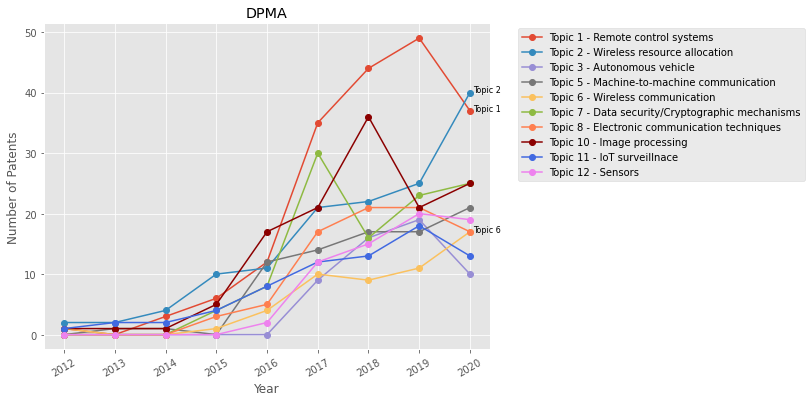

In [31]:
plt.figure(figsize=(8,6))
plt.style.use('ggplot')

plt.plot(list(table_de_top10[1]),"-o",label="Topic 1 - Remote control systems")
plt.plot(list(table_de_top10[2]),"-o",label="Topic 2 - Wireless resource allocation")
plt.plot(list(table_de_top10[3]),"-o",label="Topic 3 - Autonomous vehicle")
plt.plot(list(table_de_top10[5]),"-o",label="Topic 5 - Machine-to-machine communication")
plt.plot(list(table_de_top10[6]),"-o",label="Topic 6 - Wireless communication")
plt.plot(list(table_de_top10[7]),"-o",label="Topic 7 - Data security/Cryptographic mechanisms")
plt.plot(list(table_de_top10[8]),"-o",label="Topic 8 - Electronic communication techniques",color="coral")
plt.plot(list(table_de_top10[10]),"-o",label="Topic 10 - Image processing",color="darkred")
plt.plot(list(table_de_top10[11]),"-o",label="Topic 11 - IoT surveillnace",color="royalblue")
plt.plot(list(table_de_top10[12]),"-o",label="Topic 12 - Sensors",color="violet")


plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(range(0,9),labels=list(range(2012,2021)),rotation=30)
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.title("DPMA")


# max_number = map(list(table_de_top10.iloc[8]).index, heapq.nlargest(3, list(table_de_top10.iloc[8]))) 
# max_index = [list(table_de_top10.columns)[i] for i in list(set(max_number))]

# print(max_number)
# print(max_index)
# for i in max_index:
#     # print(max_index)
#     plt.text(8.06, list(table_de_top10[i])[-1]+0.5, "Topic {}".format(i), size=8)

# plt.text(8.06, list(table_de_top10[5])[-1]+0.5, "Topic {}".format(5), size=8)
plt.text(8.06, list(table_de_top10[2])[-1], "Topic {}".format(2), size=8)
plt.text(8.06, list(table_de_top10[1])[-1], "Topic {}".format(1), size=8)
plt.text(8.06, list(table_de_top10[6])[-1], "Topic {}".format(6), size=8)



plt.show()

## 新topic編號

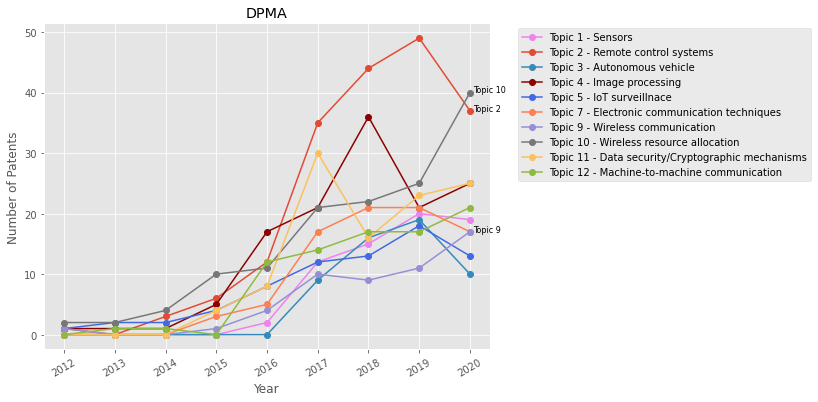

In [33]:
plt.figure(figsize=(8,6))
plt.style.use('ggplot')

plt.plot(list(table_de_top10[12]),"-o",label="Topic 1 - Sensors",color="violet")
plt.plot(list(table_de_top10[1]),"-o",label="Topic 2 - Remote control systems")
plt.plot(list(table_de_top10[3]),"-o",label="Topic 3 - Autonomous vehicle")
plt.plot(list(table_de_top10[10]),"-o",label="Topic 4 - Image processing",color="darkred")
plt.plot(list(table_de_top10[11]),"-o",label="Topic 5 - IoT surveillnace",color="royalblue")
plt.plot(list(table_de_top10[8]),"-o",label="Topic 7 - Electronic communication techniques",color="coral")
plt.plot(list(table_de_top10[6]),"-o",label="Topic 9 - Wireless communication")
plt.plot(list(table_de_top10[2]),"-o",label="Topic 10 - Wireless resource allocation")
plt.plot(list(table_de_top10[7]),"-o",label="Topic 11 - Data security/Cryptographic mechanisms")
plt.plot(list(table_de_top10[5]),"-o",label="Topic 12 - Machine-to-machine communication")


plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(range(0,9),labels=list(range(2012,2021)),rotation=30)
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.title("DPMA")


# max_number = map(list(table_de_top10.iloc[8]).index, heapq.nlargest(3, list(table_de_top10.iloc[8]))) 
# max_index = [list(table_de_top10.columns)[i] for i in list(set(max_number))]

# print(max_number)
# print(max_index)
# for i in max_index:
#     # print(max_index)
#     plt.text(8.06, list(table_de_top10[i])[-1]+0.5, "Topic {}".format(i), size=8)

# plt.text(8.06, list(table_de_top10[5])[-1]+0.5, "Topic {}".format(5), size=8)
plt.text(8.06, list(table_de_top10[2])[-1], "Topic {}".format(10), size=8)
plt.text(8.06, list(table_de_top10[1])[-1], "Topic {}".format(2), size=8)
plt.text(8.06, list(table_de_top10[6])[-1], "Topic {}".format(9), size=8)



plt.show()